In [66]:
import os, shutil

In [67]:
ls /Volumes/kenta/datasets/cancer

additional/            sample_submission.csv  train/
new/                   test/


In [68]:
ls /Volumes/kenta/datasets/cancer/new

6919.jpg    train/      validation/


In [69]:
6919

6919

In [70]:
base_dir = '/Volumes/kenta/datasets/cancer/new'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

train_type_1 = os.path.join(train_dir, 'Type_1')

train_type_2 = os.path.join(train_dir, 'Type_2')

train_type_3 = os.path.join(train_dir, 'Type_3')

validation_type_1 = os.path.join(validation_dir, 'Type_1')

validation_type_2 = os.path.join(validation_dir, 'Type_2')

validation_type_3 = os.path.join(validation_dir, 'Type_3')

test_path = '/Volumes/kenta/datasets/cancer/test/'

In [71]:
print("The number of trainining examples in type1", len(os.listdir(train_type_1)))
print("The number of trainining examples in type2", len(os.listdir(train_type_2)))
print("The number of trainining examples in type3", len(os.listdir(train_type_3)))

The number of trainining examples in type1 668
The number of trainining examples in type2 667
The number of trainining examples in type3 667


In [161]:
667 * 3

2001

In [72]:
print("The number of validation examples in type1", len(os.listdir(validation_type_1)))
print("The number of validation examples in type2", len(os.listdir(validation_type_2)))
print("The number of validation examples in type3", len(os.listdir(validation_type_3)))

The number of validation examples in type1 335
The number of validation examples in type2 334
The number of validation examples in type3 334


In [162]:
334 * 3

1002

In [18]:
from keras.applications.resnet50 import ResNet50

In [20]:
conv_base = ResNet50(weights='imagenet', 
                     include_top=False, 
                     input_shape=(197, 197, 3))

In [21]:
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 197, 197, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 203, 203, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 99, 99, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 99, 99, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [51]:
# The final feature map has shape (1,1,2048)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 2048))
    # label shoud be one-hot encoding of shape(1,3) such that [0,0,1]
    # if the true label is type3
    labels = np.zeros(shape=(sample_count, 3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(197, 197),
        batch_size=batch_size,
        class_mode='categorical')
    i= 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` onces every image has been seen once.
            break
    return features, labels

In [52]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [53]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [73]:
train_features, train_train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2001 images belonging to 3 classes.
Found 1002 images belonging to 3 classes.


In [74]:
train_features = np.reshape(train_features, (2000, 1*1*2048))
validation_features = np.reshape(validation_features, (1000, 1*1*2048))

In [75]:
# start time 1:00
# end 2:16

In [178]:
from keras import models, layers, optimizers
from keras.layers.advanced_activations import LeakyReLU

leakyRelu = LeakyReLU(alpha=0.3)
model = models.Sequential()
model.add(layers.Dense(1000, activation='relu', input_dim=1*1*2048))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(3, activation='softmax'))

In [179]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               256256    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 771       
Total params: 2,306,027
Trainable params: 2,306,027
Non-trainable params: 0
_________________________________________________________________


In [180]:
train_labels = train_train_labels

In [181]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), 
              loss='categorical_crossentropy', 
              metric=['acc'])
history = model.fit(train_features, train_labels, 
                   epochs=35, 
                   batch_size=20, 
                   validation_data=(validation_features, validation_labels))

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 2000 samples, validate on 1000 samples
Epoch 1/35
2000/2000 [==============================] - 5s - loss: 1.7993 - val_loss: 1.1045

In [182]:
model.save("resNet_2.h5")

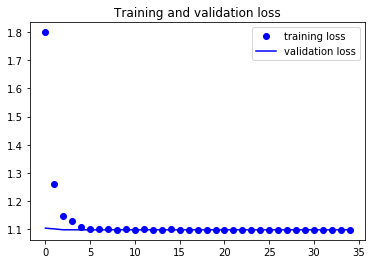

In [183]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title("Training and validation loss")
plt.legend()

In [184]:
path = '/Volumes/kenta/datasets/cancer/'
import pandas as pd
from glob import glob
import cv2
import numpy as np

In [185]:
sample_subm = pd.read_csv(path + '/sample_submission.csv')
sample_subm.head(n=3)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.168805,0.527346,0.303849
1,1.jpg,0.168805,0.527346,0.303849
2,2.jpg,0.168805,0.527346,0.303849


In [186]:
ids = sample_subm['image_name'].values
len(ids)

512

In [187]:
for num in ids:
    print("Predict for image {}".format(num))
    files = glob(test_path + num)
    image_list = []
    break

Predict for image 0.jpg


In [188]:
img = cv2.imread(files[0])

In [189]:
img.shape

(4128, 3096, 3)

In [190]:
img.reshape((1, img.shape[0]*img.shape[1]*img.shape[2])).shape

(1, 38340864)

In [191]:
img = img.reshape((1, img.shape[0]*img.shape[1]*img.shape[2]))

In [192]:
img = cv2.resize(img, (2048, 1))

In [193]:
img.flatten().shape

(2048,)

In [194]:
img.shape

(1, 2048)

In [195]:
for num in ids:
    print("Predict for image {}".format(num))
    files = glob(test_path + num)
    image_list = []

    for f in files:
        image = cv2.imread(f)
        image = image.flatten()
        image = image.astype('float32') // 255
        image = cv2.resize(image, (2048,1))
        image_list.append(image.flatten())
        
        
    image_list = np.array(image_list)
    
    
    predictions = model.predict(image_list, verbose=1, batch_size=1)
    
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_1'] = predictions[0,0]
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_2'] = predictions[0,1]
    sample_subm.loc[sample_subm['image_name'] == num , 'Type_3'] = predictions[0,2]
    
    
sample_subm.to_csv("resNet_2.csv", index=False)

Predict for image 0.jpg


/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


1/1 [==============================] - 0s
Predict for image 1.jpg
1/1 [==============================] - 0s
Predict for image 2.jpg
1/1 [==============================] - 0s
Predict for image 3.jpg
1/1 [==============================] - 0s
Predict for image 4.jpg
1/1 [==============================] - 0s
Predict for image 5.jpg
1/1 [==============================] - 0s
Predict for image 6.jpg
1/1 [==============================] - 0s
Predict for image 7.jpg
1/1 [==============================] - 0s
Predict for image 8.jpg
1/1 [==============================] - 0s
Predict for image 9.jpg
1/1 [==============================] - 0s
Predict for image 10.jpg
1/1 [==============================] - 0s
Predict for image 11.jpg
1/1 [==============================] - 0s
Predict for image 12.jpg
1/1 [==============================] - 0s
Predict for image 13.jpg
1/1 [==============================] - 0s
Predict for image 14.jpg
1/1 [==============================] - 0s
Predict for image 15.jpg
1/1 

In [196]:
ls

ResNet.ipynb                     keras-first attempt-Copy1.ipynb
Untitled.ipynb                   keras-first attempt.ipynb
Untitled1.ipynb                  metastore_db/
Untitled2.ipynb                  naive_first_1.h5
Untitled3.ipynb                  resNet_1.csv
conv-viz.ipynb                   resNet_1.h5
datasets-set-up-new.ipynb        resNet_2.csv
datasets-set-up.ipynb            resNet_2.h5
derby.log                        sum.csv


In [197]:
predictions = pd.read_csv("resNet_2.csv")

In [198]:
predictions.head(n=5)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.333235,0.332038,0.334727
1,1.jpg,0.333235,0.332038,0.334727
2,2.jpg,0.333235,0.332038,0.334727
3,3.jpg,0.333235,0.332038,0.334727
4,4.jpg,0.333235,0.332038,0.334727


In [200]:
predictions = pd.read_csv("resNet_1.csv") 

In [201]:
predictions.head(n=5)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.335051,0.332986,0.331962
1,1.jpg,0.335051,0.332986,0.331962
2,2.jpg,0.335051,0.332986,0.331962
3,3.jpg,0.335051,0.332986,0.331962
4,4.jpg,0.335051,0.332986,0.331962


In [202]:
# Fine-tune the model

In [203]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 24,113,027
Trainable params: 24,059,907
Non-trainable params: 53,120
_________________________________________________________________


In [205]:
conv_base.trainable = False

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

train_datagen = ImageDataGenerator(
     rotation_range=40, 
     width_shift_range=0.2, 
     height_shift_range=0.2, 
     shear_range=0.2, 
     zoom_range=0.2, 
     horizontal_flip=True, 
     fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(197, 197), 
        batch_size=20, 
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
       validation_dir, 
       target_size=(197, 197), 
       batch_size=20, 
       class_mode='categorical')

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=1e-4), 
              metrics=['acc'])

history = model.fit_generator(
       train_generator, 
       steps_per_epoch=2000//20, 
       epochs=100, 
       validation_data=validation_generator, 
       validation_steps=1000//20)

Found 2001 images belonging to 3 classes.
Found 1002 images belonging to 3 classes.
Epoch 1/100
100/100 [==============================] - 5609s - loss: 1.0420 - acc: 0.5225 - val_loss: 1.2386 - val_acc: 0.3330

In [ ]:
# training started at 5:09 am 